In [1]:
# Imports

import db_helpers as dbh
import db_parse as dbp
import json
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns
from matplotlib import pyplot as plt
import os
import ipywidgets as widgets
import sys
import math

In [2]:
# Connect to Database

db_name = "dos"
conn = dbh.Connection(db_name)
print('Table Row Counts')
conn.row_counts()

Table Row Counts
{'data': 967260,
 'experiments': 144,
 'hosts': 17,
 'materializations': 1,
 'results': 1744,
 'revisions': 1,
 'sessions': 1}


In [3]:
# Select Revisions

revisions = conn.db_query("select distinct nickname from revisions")[0]
widget_revisions = widgets.SelectMultiple(
            options=revisions,
            value=revisions,
            rows=len(revisions),
            description='Revisions',
            disabled=False
)
widget_revisions

SelectMultiple(description='Revisions', index=(0,), options=('test',), rows=1, value=('test',))

In [4]:
# Select Materializations

revisions = list(widget_revisions.value)
materializations = conn.db_query(
    """
    SELECT distinct materializations.nickname
    FROM materializations
    JOIN revisions ON materializations.revision = revisions.id
    WHERE revisions.nickname = ANY(%s)
    """, [revisions]
)[0]
widget_materializations = widgets.SelectMultiple(
            options=materializations,
            value=materializations,
            rows=len(materializations),
            description='Materializations',
            disabled=False
)
widget_materializations

SelectMultiple(description='Materializations', index=(0,), options=('net1',), rows=1, value=('net1',))

In [5]:
# Select Sessions

materializations = list(widget_materializations.value)
sessions = conn.db_query(
    """
    SELECT distinct sessions.nickname
    FROM sessions
    JOIN materializations ON sessions.materialization = sessions.id
    WHERE materializations.nickname = ANY(%s)
    """, [materializations]
)[0]
widget_sessions = widgets.SelectMultiple(
            options=sessions,
            value=sessions,
            rows=len(sessions),
            description='Sessions',
            disabled=False
)
widget_sessions

SelectMultiple(description='Sessions', index=(0,), options=('foo',), rows=1, value=('foo',))

In [6]:
# Query Database (Re-run after selecting new sessions)

materializations = list(widget_materializations.value)
revisions = list(widget_revisions.value)
sessions = list(widget_sessions.value)

df = pd.DataFrame(
    conn.db_query(
    f"""
    SELECT
        hostname,
        hostnum::int AS Client,
        (settings->>'attack_type') AS attack_type,
        (settings->>'mitigation') AS Mitigation,
        (settings->>'bottleneck_capacity')::int,
        (settings->>'bottleneck_latency')::int,
        (settings->>'bottleneck_loss')::float,
        (settings->>'client_interval')::float,
        (settings->>'mitigated_attack_type') AS mitigated_attack,
        (settings->>'syn_pow_verifier') AS Verifier,
        (settings->>'n_attackers')::int AS Attackers,
        (settings->>'client_app') AS client_app,
        (settings->>'file_size')::int AS file_size,
        (settings->>'attacker_busywait')::int AS busywait,
        (settings->>'attacker_cpu_limit')::int AS attacker_cpu_limit,
        (settings->>'n_clients')::int AS Clients,
        metric,
        ub,
        mb,
        ua,
        ma,
        efficacy,
        overhead,
        threat,
        damage,
        efficacy_pct,
        efficacy_pct_threat,
        efficacy_relative,
        overhead_pct,
        threat_pct,
        damage_pct
    FROM results
    JOIN experiments ON results.experiment = experiments.id
    JOIN hosts ON results.host = hosts.id
    JOIN sessions ON experiments.session = sessions.id
    WHERE sessions.nickname = ANY(%s)
    """, [sessions]
    ), columns=["Hostname", "Client", "Attack", "Mitigation", "Bottleneck Capacity", "Bottleneck Latency", "Bottleneck Loss",
                "Client Delay", "Mitigated Attack", "Verifier", "Attackers", "Client Application", "File Size",
                "Attacker Busywait", "Attacker CPU Limit", "Number of Clients", "Metric", "UB", "MB", "UA", "MA",
                "Efficacy", "Overhead", "Threat", "Damage", "Efficacy Percent", "Efficacy Percent Threat",
                "Relative Efficacy", "Overhead Percent", "Threat Percent", "Damage Percent"]
)

In [7]:
# Map Strings

mitigation_k_map = {
    'syn_pow_0': 0,
    'syn_pow_8': 8,
    'syn_pow_32': 32,
    'syn_pow_64': 64,
    'syn_pow_256': 256,
    'syn_pow_1024': 1024
}
df["Client/Server k"] = df["Mitigation"].map(mitigation_k_map)

mitigation_map = {
    'syn_pow_0': 'eBPF No-Op',
    'syn_pow_8': 'SYN PoW (k=8)',
    'syn_pow_32':'SYN PoW (k=32)',
    'syn_pow_64': 'SYN PoW (k=64)',
    'syn_pow_256': 'SYN PoW (k=256)',
    'syn_cookies': 'SYN Cookies',
    'syn_pow_8_cookies': 'SYN Cookies + PoW (k=8)',
    'syn_pow_64_cookies': 'SYN Cookies + PoW (k=64)',
    'syn_pad': 'SYN Padding',
    'syn_pad_cookies': 'SYN Cookies + Padding',
    'quic_retry': 'QUIC Retry',
    'all': 'All Combined'
}
df["Mitigation"] = df["Mitigation"].map(mitigation_map)

mitigated_attack_k_map = {
    'syn_flood': 0,
    'syn_flood_pow_8': 8,
    'syn_flood_pow_32': 32,
    'syn_flood_pow_64': 64,
    'syn_flood_pow_256': 256,
    'syn_flood_pow_1024': 1024
}
df["Attacker k"] = df["Mitigated Attack"].map(mitigated_attack_k_map)

flood_type_map = {
    'syn_flood': 'Dumb',
    'syn_flood_pow_8': 'Smart',
    'syn_flood_pow_32': 'Smart',
    'syn_flood_pow_64': 'Smart',
    'syn_flood_pow_256': 'Smart',
    'syn_flood_pow_1024': 'Smart',
    'syn_flood_padded': 'Smart'
}

attack_map = {
    'syn_flood': 'TCP SYN',
    'quic_prebuilt': 'QUIC Initial (Prebuilt)',
    'quic_curl': 'QUIC Initial (curl)',
    'https_curl': 'TCP SYN (curl)',
    'mixed_curl': 'SYN+QUIC (curl)'
}
df["Attack"] = df["Attack"].map(attack_map)
df["Mitigated Attack"] = df["Mitigated Attack"].map(attack_map)

client_app_map = {
    'tcp': 'TCP Setup',
    'http': 'HTTP',
    'https': 'HTTPS',
    'http2': 'HTTPS 2',
    'http3': 'QUIC',
    'https_keep': 'HTTPS (Keep-Alive)',
    'http3_keep': 'QUIC (Keep-Alive)'
}
df["Application"] = df["Client Application"].map(client_app_map)

client_location_map = {
    0: 'A',
    1: 'A',
    2: 'A',
    3: 'B',
    4: 'B',
    5: 'B',
    6: 'C',
    7: 'C',
    8: 'C',
    9: 'D',
    10: 'D',
    11: 'D',
}
df["Client Subnet"] = df["Client"].map(client_location_map)
df["Client Location"] = df["Client Subnet"].map({
    'A': 'LAN',
    'B': 'Local',
    'C': 'Remote',
    'D': 'Sink'
})

verifier_map = {
    's0': 'Server',
    'firewall': 'Firewall',
    'edge_router': 'Edge Routers'
}
df["Verifier Location"] = df["Verifier"].map(verifier_map)

df["Attack Strength"] = df["Attackers"] * 0.01 * df["Attacker CPU Limit"]

df["Attack/Mitigation"] = np.where(
    df['Attack'] == df['Mitigated Attack'],
    df['Attack'] + ' / ' + df['Mitigation'],
    df['Attack'] + ' (' + df['Mitigated Attack'] + ') / ' + df['Mitigation']
)

In [8]:
# Select Performance Metric #

performance_metrics = tuple(df['Metric'].unique().tolist())
metric_widget = widgets.RadioButtons(
    options = performance_metrics,
    value = 'Transactions per Second',
    description='Metric'
)
metric_widget

RadioButtons(description='Metric', index=1, options=('Transaction Duration', 'Transactions per Second', 'Trans…

In [9]:
# List Available Parameter Values

independent_metrics = ['Attack/Mitigation',
                       'Client', 'Number of Clients', 'Application', 'File Size', 'Client Delay', 
                       'Bottleneck Capacity', 'Bottleneck Latency', 'Bottleneck Loss',
                       'Attackers', 'Attacker Busywait', 'Attacker CPU Limit',
                       #'Attack', 'Mitigation', 'Mitigated Attack',
                        #'Verifier', 'Hostname', 'Client Application'
]
dependent_metrics = ['UB', 'UA', 'MB', 'MA',
                     'Threat', 'Damage', 'Efficacy', 'Overhead',
                     'Threat Percent', 'Damage Percent', 'Efficacy Percent', 'Overhead Percent',
                     'Efficacy Percent Threat', 'Relative Efficacy',
                     #
]

for col in df:
    if col in independent_metrics:
        print("{}: {}".format(col, df[col].unique()))

Client: [0 3 2 1 5 4 6 7 8 9]
Bottleneck Capacity: [-1]
Bottleneck Latency: [-1]
Bottleneck Loss: [-1.]
Client Delay: [0.]
Attackers: [3]
File Size: [   1000 1000000]
Attacker Busywait: [0]
Attacker CPU Limit: [100]
Number of Clients: [ 4  6  8 10  1  2]
Application: ['QUIC' 'QUIC (Keep-Alive)' 'HTTPS' 'HTTPS (Keep-Alive)']
Attack/Mitigation: ['TCP SYN (curl) / SYN Cookies' 'QUIC Initial (curl) / QUIC Retry'
 'SYN+QUIC (curl) / All Combined']


In [40]:
# Map Parameters to Plot Features

x_axis_widget = widgets.Dropdown(
    options = tuple(sorted(independent_metrics)),
    value = 'Number of Clients',
    description='X-Axis'
)

hue_widget = widgets.Dropdown(
    options = tuple(sorted(independent_metrics)),
    value = 'Application',
    description= 'Hue'
)

widgets.VBox(children=[x_axis_widget, hue_widget])
# accordian.set_title(0, 'X-Axis')
# accordian.set_title(1, 'Hue')
# accordian

In [11]:
# Filter data.  Command/Control-click to select multiple values.  All selected by default. #
widget_filter = []

for col in df:
    if col in independent_metrics:
        vals = tuple(sorted(tuple(df[col].unique().tolist())))
        if len(vals) < 2:
            continue
        _v = vals[0]
        if type(_v) == float:
            if math.isnan(_v):
                continue
        # try:
        widget_filter.append(widgets.SelectMultiple(
            options=vals,
            value=vals,
            rows=len(vals),
            description=col,
            disabled=False
        ))
        # except:
        #      print([i.type() for i in vals])

accordian = widgets.Accordion(children=widget_filter)
for i in range(len(widget_filter)):
    _widget = widget_filter[i]
    accordian.set_title(i, _widget.description)
    # _widget.description = ''
accordian

Accordion(children=(SelectMultiple(description='Client', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), options=(0, 1, …

In [30]:
# !!! Run from here down after updating filters !!! #

In [31]:
# Update and Apply Selections

df_plt = df.loc[df['Metric'] == metric_widget.value]
for widget in widget_filter:
    if len(widget.value) > 0:
        df_plt = df_plt.loc[df_plt[widget.description].isin(list(widget.value))]

metric = metric_widget.value
x_axis = x_axis_widget.value
hue = hue_widget.value

In [32]:
# Display Subsetted Parameters

for col in df_plt:
    if col in independent_metrics:
        print("{}: {}".format(col, df_plt[col].unique()))

Client: [0 3 2 1 5 4 6 7 8 9]
Bottleneck Capacity: [-1]
Bottleneck Latency: [-1]
Bottleneck Loss: [-1.]
Client Delay: [0.]
Attackers: [3]
File Size: [1000]
Attacker Busywait: [0]
Attacker CPU Limit: [100]
Number of Clients: [ 8  4 10  1  2  6]
Application: ['QUIC' 'HTTPS']
Attack/Mitigation: ['QUIC Initial (curl) / QUIC Retry']


In [33]:
# (Optional) Specify Value Orders
# Leave as None to use default orders
x_order = None 
hue_order = None

In [34]:
# Configure Plot Aesthetics

sns.set_theme(style="whitegrid")
fig_width=12
fig_height=6
share_x = True
share_y = True
palette = 'colorblind'

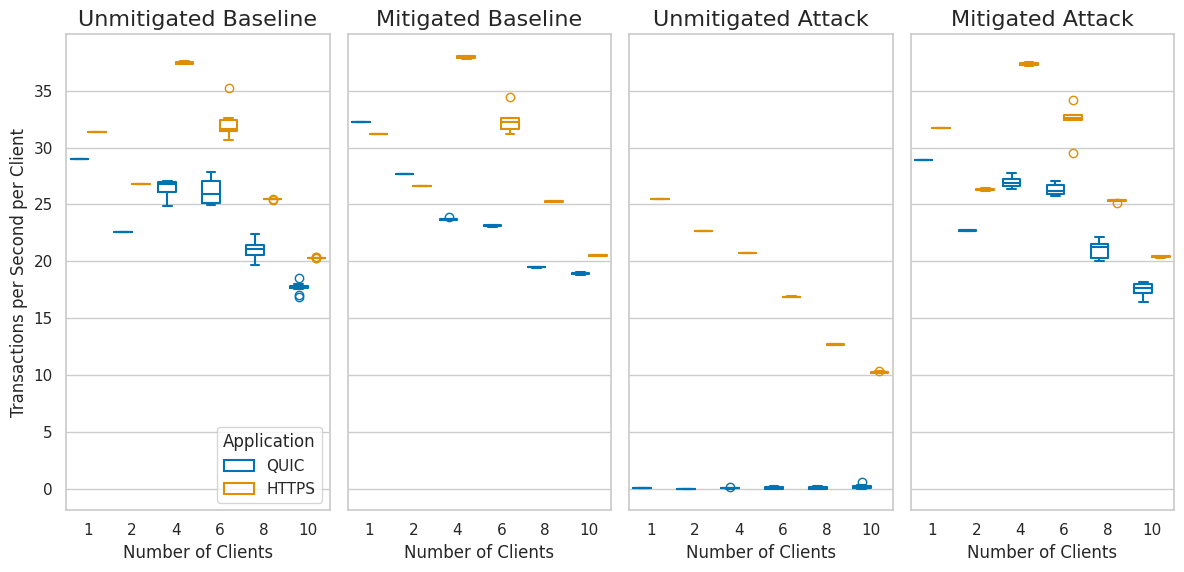

In [35]:
# Draw Primary Metric Box Plots (UB, MB, UA, MA)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(fig_width, fig_height), sharex=share_x, sharey=share_y)
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1,  # Adjust the left margin
                    right=0.9,  # Adjust the right margin
                    bottom=0.1,  # Adjust the bottom margin
                    top=0.9,     # Adjust the top margin
                    wspace=0.1,  # Adjust the width space between subplots
                    hspace=0.5)  # Adjust the height space between subplots

axis_metrics = [
    (ax1, 'UB'),
    (ax2, 'MB'),
    (ax3, 'UA'),
    (ax4, 'MA')
]

for i in range(len(axis_metrics)):
    if i == 0:
        legend = 'auto'
    else:
        legend = None

    sns.boxplot(
        ax=axis_metrics[i][0],
        data=df_plt,
        x=x_axis,
        order=x_order,
        hue=hue,
        y=axis_metrics[i][1],
        palette=palette,
        hue_order=hue_order,
        fill=False,
        legend=legend
    )

ax1.set_ylabel(metric + ' per Client')
ax1.set_title('Unmitigated Baseline', fontsize=16)
ax2.set_title('Mitigated Baseline', fontsize=16)
ax3.set_title('Unmitigated Attack', fontsize=16)
ax4.set_title('Mitigated Attack', fontsize=16)
fig.tight_layout(rect=[0, 0.01, 1, 0.99])

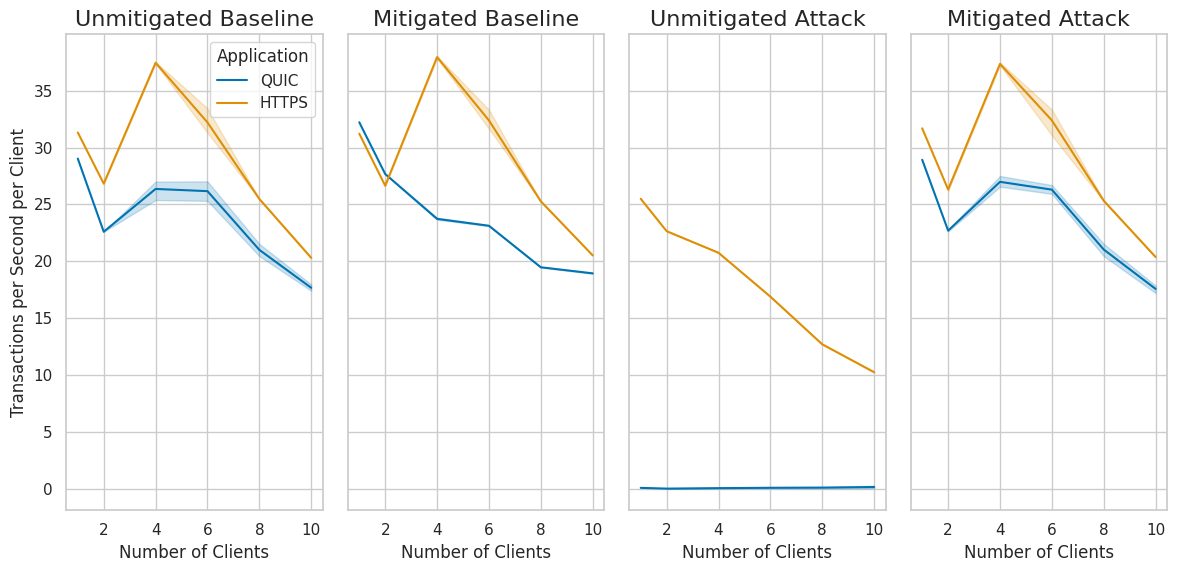

In [36]:
# Draw Primary Metric Line Plots (UB, MB, UA, MA)

sns.set_theme(style="whitegrid")
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(fig_width, fig_height), sharex=share_x, sharey=share_y)
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1,  # Adjust the left margin
                    right=0.9,  # Adjust the right margin
                    bottom=0.1,  # Adjust the bottom margin
                    top=0.9,     # Adjust the top margin
                    wspace=0.1,  # Adjust the width space between subplots
                    hspace=0.5)  # Adjust the height space between subplots

axis_metrics = [
    (ax1, 'UB'),
    (ax2, 'MB'),
    (ax3, 'UA'),
    (ax4, 'MA')
]

for i in range(len(axis_metrics)):
    if i == 0:
        legend = 'auto'
    else:
        legend = None

    sns.lineplot(
        ax=axis_metrics[i][0],
        data=df_plt,
        x=x_axis,
        hue=hue,
        y=axis_metrics[i][1],
        palette=palette,
        hue_order=hue_order,
        legend=legend
    )

ax1.set_ylabel(metric + ' per Client')
ax1.set_title('Unmitigated Baseline', fontsize=16)
ax2.set_title('Mitigated Baseline', fontsize=16)
ax3.set_title('Unmitigated Attack', fontsize=16)
ax4.set_title('Mitigated Attack', fontsize=16)
fig.tight_layout(rect=[0, 0.01, 1, 0.99])

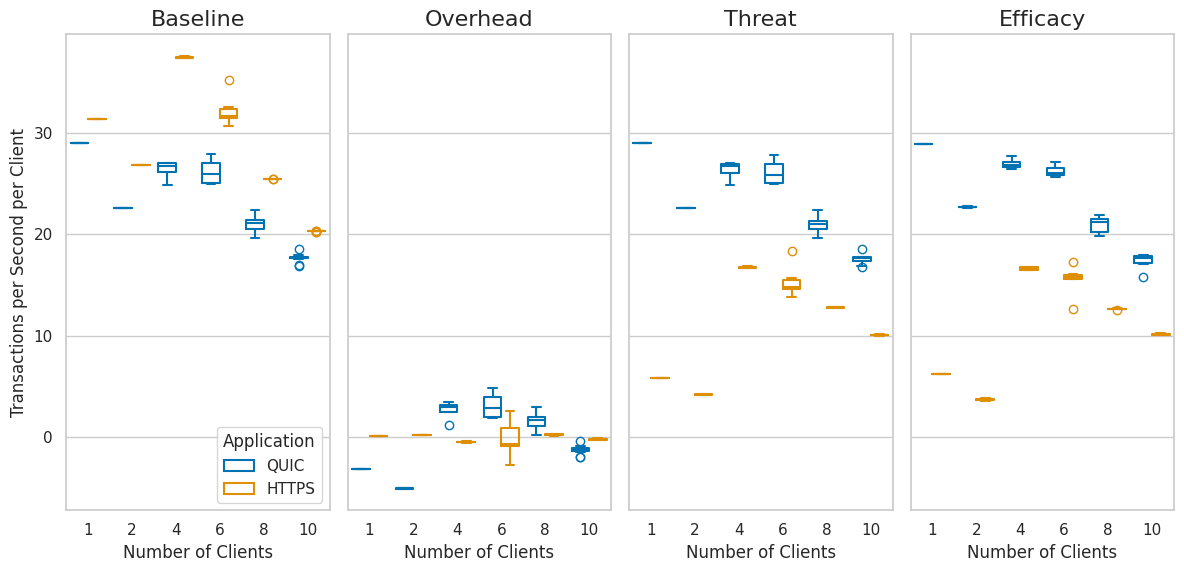

In [37]:
# Draw Secondary Metric Box Plots (Baseline, Overhead, Threat, Efficacy)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(fig_width, fig_height), sharex=share_x, sharey=share_y)
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1,  # Adjust the left margin
                    right=0.9,  # Adjust the right margin
                    bottom=0.1,  # Adjust the bottom margin
                    top=0.9,     # Adjust the top margin
                    wspace=0.1,  # Adjust the width space between subplots
                    hspace=0.5)  # Adjust the height space between subplots

axis_metrics = [
    (ax1, 'UB'),
    (ax2, 'Overhead'),
    (ax3, 'Threat'),
    (ax4, 'Efficacy')
]

for i in range(len(axis_metrics)):
    if i == 0:
        legend = 'auto'
    else:
        legend = None

    sns.boxplot(
        ax=axis_metrics[i][0],
        data=df_plt,
        x=x_axis,
        order=x_order,
        hue=hue,
        y=axis_metrics[i][1],
        palette=palette,
        hue_order=hue_order,
        fill=False,
        legend=legend
    )

ax1.set_ylabel(metric + ' per Client')
ax1.set_title('Baseline', fontsize=16)
ax2.set_title('Overhead', fontsize=16)
ax3.set_title('Threat', fontsize=16)
ax4.set_title('Efficacy', fontsize=16)
fig.tight_layout(rect=[0, 0.01, 1, 0.99])

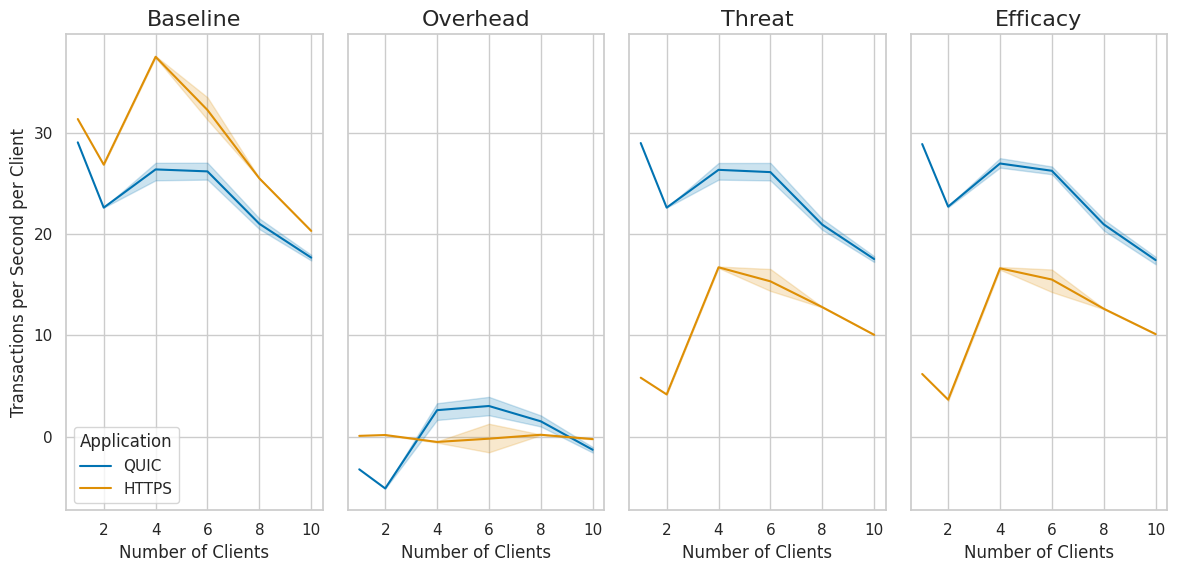

In [38]:
# Draw Secondary Metric Line Plots (Baseline, Overhead, Threat, Efficacy)

sns.set_theme(style="whitegrid")
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(fig_width, fig_height), sharex=share_x, sharey=share_y)
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1,  # Adjust the left margin
                    right=0.9,  # Adjust the right margin
                    bottom=0.1,  # Adjust the bottom margin
                    top=0.9,     # Adjust the top margin
                    wspace=0.1,  # Adjust the width space between subplots
                    hspace=0.5)  # Adjust the height space between subplots

axis_metrics = [
    (ax1, 'UB'),
    (ax2, 'Overhead'),
    (ax3, 'Threat'),
    (ax4, 'Efficacy')
]

for i in range(len(axis_metrics)):
    if i == 0:
        legend = 'auto'
    else:
        legend = None

    sns.lineplot(
        ax=axis_metrics[i][0],
        data=df_plt,
        x=x_axis,
        hue=hue,
        y=axis_metrics[i][1],
        palette=palette,
        hue_order=hue_order,
        legend=legend
    )

ax1.set_ylabel(metric + ' per Client')
ax1.set_title('Baseline', fontsize=16)
ax2.set_title('Overhead', fontsize=16)
ax3.set_title('Threat', fontsize=16)
ax4.set_title('Efficacy', fontsize=16)
fig.tight_layout(rect=[0, 0.01, 1, 0.99])